In [7]:
import sys
from importlib.util import spec_from_loader, module_from_spec
from importlib.machinery import SourceFileLoader 
spec = spec_from_loader("wirexp", SourceFileLoader("wirexp", "./wirexp"))
wirexp = module_from_spec(spec)
sys.modules['wirexp'] = wirexp

from mando import main, command
import configparser
from wireguard import generate_conf
from fabric.connection import Connection
from fabric import ThreadingGroup
import os
import time
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from paramiko import RSAKey
import logging
from pathlib import Path
import enoslib as en
import socket
import secrets
import glob
import math
# from wirexp import init_config, get_stats

In [10]:

def get_stats(path, config):
    network_metrics = [
        [
            "IFACE",
            "rxpck/s",
            "txpck/s",
            "rxkB/s",
            "txkB/s",
            "rxcmp/s",
            "txcmp/s",
            "rxmcst/s",
            "%ifutil",
        ],
        [
            "errIFACE",
            "rxerr/s",
            "txerr/s",
            "coll/s",
            "rxdrop/s",
            "txdrop/s",
            "txcarr/s",
            "rxfram/s",
            "rxfifo/s",
            "txfifo/s",
        ],
    ]  # the order of the metrics are important
    other_headers = [
        "hostname",
        "interval",
        "datetime",
        "CPU",
        "%user",
        "%nice",
        "%system",
        "%iowait",
        "%steal",
        "%idle",
    ]
    interfaces = [
        config["xp"]["network_interface"],
        "wg",
    ]  # the order of the interfaces is important
    headers = np.concatenate(
        [
            other_headers,
            [
                "_".join([interface, metric])
                for interface in interfaces
                for metric in network_metrics[0]
            ],
            [
                "_".join([interface, metric])
                for interface in interfaces
                for metric in network_metrics[1]
            ],
        ]
    ).tolist()

    stat = pd.read_csv(
        path,
        header=None,
        sep=";",
        names=headers,
        skiprows=[0],
    )
    # convert the timestamp from (YYYY-MM-DD HH:MM:SS) to timestamp
    stat["timestamp"] = pd.to_datetime(stat["datetime"])
    stat["seconds"] = stat["timestamp"].astype(np.int64).div(10**9).astype(np.int64)
    # convert the timestamp to start from 0
    stat["timestamp"] = stat["timestamp"] - stat["timestamp"].min()
    stat["seconds"] = stat["seconds"] - stat["seconds"].min()
    stat["%cpu"] = 100 - stat["%idle"]
    stat["wg_throughput_MB_per_s"] = (stat["wg_rxkB/s"] + stat["wg_txkB/s"]) / 1024
    stat["eth_throughput_MB_per_s"] = (
        stat[f'{config["xp"]["network_interface"]}_rxkB/s']
        + stat[f'{config["xp"]["network_interface"]}_txkB/s']
    ) / 1024
    return stat

def get_cpu_stats(path, config):
    active_cores = config.getint('xp', 'active_cores')
    cpus =  list(range(1, config.getint('xp', 'server_cores', fallback=active_cores)+1))
    headers = ['global'] + [f"core{i}" for i in cpus]
    stat = pd.read_csv(
        path,
        header=None,
        sep=";",
        names=headers,
        skiprows=[0],
    )
    for cpu in headers:
        stat[cpu] = 100 - stat[cpu]
    return stat

def init_config(configfile, dest: str = ""):
    configfile = os.path.abspath(configfile)
    current_path = os.getcwd()

    # check if the config file exists
    if not os.path.exists(configfile):
        print(f"Config file {configfile} does not exist.")
        return

    config = configparser.ConfigParser(inline_comment_prefixes=(";",))
    config.read(configfile)
    # check if the config file has the required sections and keys
    if not reduce(lambda acc, x: acc and x in config.sections(), ["auth", "xp"], True):
        print("Config file must have auth and xp sections.")
        return

    # setup destination
    dest = dest if dest else config.get("xp", "dest", fallback=os.path.join(current_path, os.path.basename(configfile)))
    path = os.path.abspath(dest)
    os.makedirs(path, exist_ok=True)

    return config, current_path, path


In [11]:
plt.style.use("seaborn-v0_8-whitegrid")
config, current_path, path = init_config('xps/cpu_payload_25_hyper_clients_10.ini', '')
plots_path = os.path.join(path, "plots")
os.makedirs(plots_path, exist_ok=True)
multiple_payload = config.has_option("xp", "payloads")
multiple_throughputs = config.has_option("xp", "throughputs")
scenario_string = ("" if multiple_throughputs else f"throughput:{config.get('xp', 'throughput')}req/s;") +  ("" if multiple_payload else f"""forward:{config.get('xp', 'client_payload')+"MB" if config.getint('xp', 'client_payload', fallback=0) > 0 else "None"}; backward:{config.get('xp', 'target_payload')+"MB" if config.getint('xp', 'target_payload', fallback=0) > 0 else "None"};""") + ("threaded:True;" if config.getboolean("xp", "threaded", fallback=False) else "threaded:False;")
trace = config.getboolean("xp", "trace", fallback=False)
active_cores = config.getint('xp', 'active_cores')
cpus =  ['global'] + [ "core" + str(i) for i in list(range(1, config.getint('xp', 'server_cores', fallback=active_cores)+1))]
max_cpu_load = 100
n_clients = config.getint('xp', 'n_clients', fallback=1)

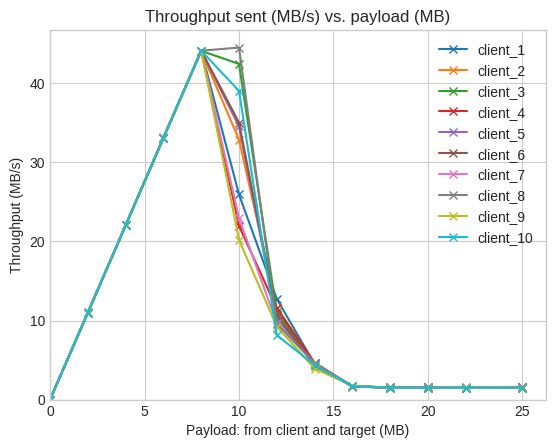

In [19]:

payloads = [int(x) for x in config["xp"]["payloads"].split(",")]
normalized_payloads = [ x*n_clients for x in payloads]
version = 'encrypted'
ncols = 4
nrows = math.ceil(n_clients / ncols)
stats = {}
for i in range(1, n_clients+1):
    stats[f'client_{i}'] = reduce(
        lambda acc, payload: acc + [get_stats(
            os.path.join(path, f"stat_client_{i}_{config['xp']['throughput']}_{payload}_{payload}_{version}.csv"),
            config
        )["eno1_txkB/s"].median() / 1024],
        payloads,
        []
    )
ax = pd.DataFrame(stats, index=payloads).plot.line(
    xlabel="Payload: from client and target (MB)",
    ylabel="Throughput (MB/s)",
    title="Throughput sent (MB/s) vs. payload (MB)",
    marker='x',
)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
plt.legend()
plt.show()

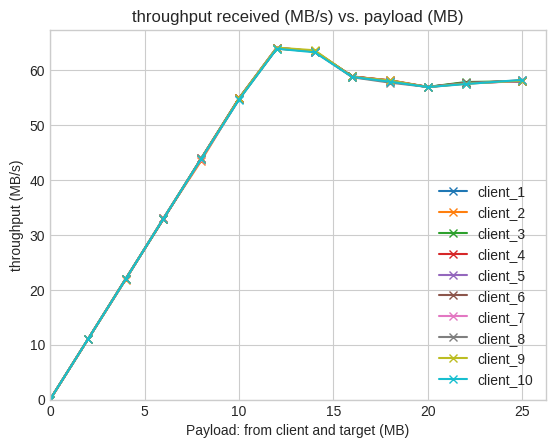

In [20]:

payloads = [int(x) for x in config["xp"]["payloads"].split(",")]
normalized_payloads = [ x*n_clients for x in payloads]
version = 'encrypted'
ncols = 4
nrows = math.ceil(n_clients / ncols)
stats = {}
for i in range(1, n_clients+1):
    stats[f'client_{i}'] = reduce(
        lambda acc, payload: acc + [get_stats(
            os.path.join(path, f"stat_client_{i}_{config['xp']['throughput']}_{payload}_{payload}_{version}.csv"),
            config
        )["eno1_rxkB/s"].median() / 1024],
        payloads,
        []
    )
ax = pd.DataFrame(stats, index=payloads).plot.line(
    xlabel="Payload: from client and target (MB)",
    ylabel="throughput (MB/s)",
    title="throughput received (MB/s) vs. payload (MB)",
    marker='x',
)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
plt.legend()
plt.show()